In [ ]:
import pandas as pd

# Data contains 16 days before and after starting medication
# Load the data
pre_med_df = pd.read_csv("data/premed.csv")
post_med_df = pd.read_csv("data/postmed.csv")


In [19]:
# Ensure both datasets have the same columns
common_columns = list(set(pre_med_df.columns) & set(post_med_df.columns))
pre_med_df = pre_med_df[common_columns]
post_med_df = post_med_df[common_columns]

In [20]:
common_columns

['Average HRV',
 'Steps',
 'REM Sleep Duration',
 'Temperature Deviation (°C)',
 'Lowest Resting Heart Rate',
 'Equivalent Walking Distance',
 'Average Resting Heart Rate',
 'Sleep Latency',
 'Rest Time',
 'date',
 'Readiness Score',
 'Sleep Score',
 'Total Sleep Duration',
 'Average MET',
 'High Activity Time',
 'Deep Sleep Duration']

In [21]:
# Remove non-numeric columns (like date)
numeric_columns = pre_med_df.select_dtypes(include=['number']).columns

In [25]:
from scipy.stats import ttest_rel

# Perform paired t-tests for each numeric column
paired_stat_results = {}
for col in numeric_columns:
    # Ensure equal sample sizes by trimming to the shortest length
    min_length = min(len(pre_med_df[col]), len(post_med_df[col]))
    stat, p_value = ttest_rel(pre_med_df[col][:min_length], post_med_df[col][:min_length], nan_policy='omit')
    paired_stat_results[col] = p_value

# Identify statistically significant differences (p < 0.05)
paired_significant_results = {col: p for col, p in paired_stat_results.items() if p < 0.05}

# Convert results to DataFrame and display
paired_df_results = pd.DataFrame(list(paired_stat_results.items()), columns=["Metric", "P-value"])
paired_df_results["Statistically Significant"] = paired_df_results["P-value"] < 0.05



In [26]:
paired_df_results

,Metric,P-value,Statistically Significant
0,Average HRV,0.000954,True
1,Steps,0.020953,True
2,REM Sleep Duration,0.918016,False
3,Temperature Deviation (°C),0.755494,False
4,Lowest Resting Heart Rate,0.001135,True
5,Equivalent Walking Distance,0.259591,False
6,Average Resting Heart Rate,0.002964,True
7,Sleep Latency,0.044253,True
8,Rest Time,0.025935,True
9,Readiness Score,0.004714,True


In [27]:
pre_avg = round(pre_med_df[numeric_columns].mean(), 2)
post_avg = round(post_med_df[numeric_columns].mean(), 2)

# Create a DataFrame with the results
avg_comparison_df = pd.DataFrame({
    "Metric": numeric_columns,
    "Pre-Medication Average": pre_avg.values,
    "Post-Medication Average": post_avg.values
})


In [28]:
avg_comparison_df

,Metric,Pre-Medication Average,Post-Medication Average
0,Average HRV,76.44,62.38
1,Steps,17712.76,13243.81
2,REM Sleep Duration,4400.62,4248.46
3,Temperature Deviation (°C),-0.17,-0.12
4,Lowest Resting Heart Rate,52.81,56.46
5,Equivalent Walking Distance,20007.59,17294.88
6,Average Resting Heart Rate,59.20,63.54
7,Sleep Latency,894.38,583.85
8,Rest Time,31694.12,26182.50
9,Readiness Score,78.19,68.54


In [34]:
# 37 minutes less total sleep, not statistically significant at .05 level tho
avg_comparison_df.query("Metric == 'Total Sleep Duration'").apply(lambda x: (x["Post-Medication Average"] - x["Pre-Medication Average"])/60, axis=1)

11   -37.7645
dtype: float64

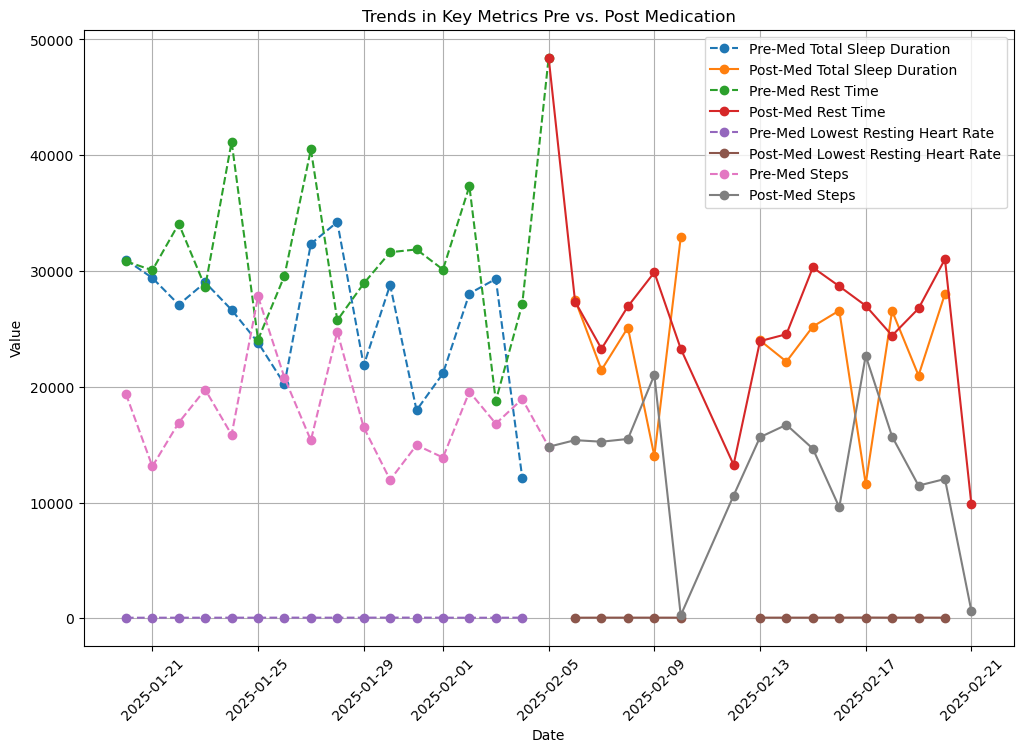

In [36]:
import matplotlib.pyplot as plt

# Convert date columns to datetime for proper plotting
pre_med_df["date"] = pd.to_datetime(pre_med_df["date"])
post_med_df["date"] = pd.to_datetime(post_med_df["date"])

# Sort by date
pre_med_df = pre_med_df.sort_values("date")
post_med_df = post_med_df.sort_values("date")

# Select key metrics for trend visualization
metrics_to_plot = ["Total Sleep Duration", "Rest Time", "Lowest Resting Heart Rate", "Steps"]

# Plot trends over time
plt.figure(figsize=(12, 8))

for metric in metrics_to_plot:
    plt.plot(pre_med_df["date"], pre_med_df[metric], label=f"Pre-Med {metric}", linestyle="dashed", marker="o")
    plt.plot(post_med_df["date"], post_med_df[metric], label=f"Post-Med {metric}", linestyle="solid", marker="o")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Trends in Key Metrics Pre vs. Post Medication")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [39]:
## Cohen's d effect size

import numpy as np
import pandas as pd

# Function to calculate Cohen's d
def cohen_d(x, y):
    min_length = min(len(x), len(y))
    x, y = x[:min_length], y[:min_length]
    return (np.mean(y) - np.mean(x)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)

# Ensure we only use numeric columns
numeric_columns = pre_med_df.select_dtypes(include=['number']).columns

# Calculate Cohen's d for each numeric column
cohen_d_results = {col: cohen_d(pre_med_df[col], post_med_df[col]) for col in numeric_columns}

# Convert results to DataFrame
cohen_d_df = pd.DataFrame(list(cohen_d_results.items()), columns=["Metric", "Cohen's d"])

# Display results
cohen_d_df

,Metric,Cohen's d
0,Average HRV,-1.414445
1,Steps,-0.897925
2,REM Sleep Duration,-0.081208
3,Temperature Deviation (°C),0.228352
4,Lowest Resting Heart Rate,1.143538
5,Equivalent Walking Distance,-0.416195
6,Average Resting Heart Rate,1.244416
7,Sleep Latency,-0.666466
8,Rest Time,-0.628397
9,Readiness Score,-0.953223
